In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd 
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from seaborn import heatmap as hmap
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse

In [2]:
def dataload(files,hlist):
    dfl = pd.read_csv(files[0])
    dfl = dfl[hlist]
    dfr = pd.read_csv(files[1])
    dfr = dfr[hlist]
    intx = np.linspace(0,100, 50000)
    lx = np.linspace(0,100,dfl.shape[0])
    rx = np.linspace(0,100,dfr.shape[0])
    ly = dfl.to_numpy().T
    ry = dfr.to_numpy().T
    lint = interp1d(lx,ly,kind = 'linear')
    rint = interp1d(rx,ry,kind = 'linear')
    yintl = lint(intx).T
    yintr = rint(intx).T
    yout = np.concatenate((yintl,yintr), axis=1)
    ystand = np.zeros(np.shape(yout))
    for cid in range(np.shape(yout)[1]):
        ystand[:,cid] = preprocessing.scale(yout[:,cid])
    return ystand

In [84]:
filelist = pd.read_excel('filepairs.xlsx', index_col=0) 
hlist = pd.read_excel('header.xlsx', index_col=0)
gtlist = pd.read_excel('groundtruth.xlsx', index_col=0)

In [4]:
inputdata = np.zeros([filelist.shape[0],50000,70])
for fid in range(filelist.shape[0]):
    inputdata[fid] = (dataload(filelist.iloc[fid],hlist.iloc[:,0]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered w

In [5]:
print(np.shape(inputdata))

(106, 50000, 70)


In [20]:
def custom_pca(features,n_comp):
    pca = decomposition.PCA(n_components=n_comp)
    #temporal PC score by features
    temp_pc_score = np.zeros([n_comp,np.shape(features)[0],np.shape(features)[2]])
    feat_pc_score = np.zeros([n_comp,np.shape(features)[0],np.shape(features)[1]])
    for p in range(np.shape(features)[2]):
        idata = features[:,:,p]
        temp_pc_score[:,:,p] = pca.fit_transform(idata).T
    #feature PC score by time
    for q in range(np.shape(features)[1]):
        idata = features[:,q,:]
        feat_pc_score[:,:,q] = pca.fit_transform(idata).T
    return temp_pc_score, feat_pc_score

In [42]:
t_score, f_score = custom_pca(inputdata, 2)

In [43]:
t_score1 = t_score2[0]
t_score2 = t_score2[1]
f_score1 = f_score2[0]
f_score2 = f_score2[1]

In [44]:
print(np.shape(t_score))
print(np.shape(f_score))
print(np.shape(t_score1))
print(np.shape(f_score1))

(2, 106, 70)
(2, 106, 50000)
(106, 70)
(106, 50000)


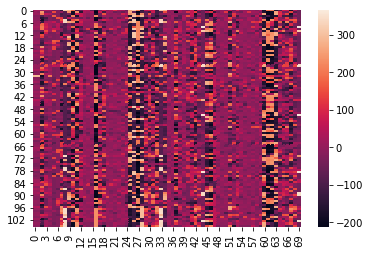

In [45]:
hmap(t_score1)

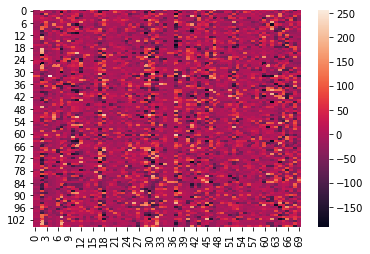

In [46]:
hmap(t_score2)

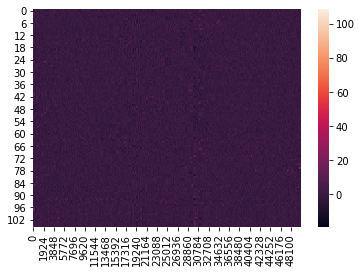

In [47]:
hmap(f_score1)

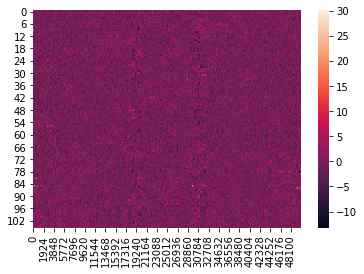

In [48]:
hmap(f_score2)

In [11]:
def get_gmm_vals(gmm, X, data_dimension, number_of_gaussian, label=True, ax=None):
    pos_full = np.zeros((number_of_gaussian,data_dimension))
    covar_full = np.zeros((number_of_gaussian,data_dimension,data_dimension))
    labels = gmm.fit(X).predict(X)
    w_factor = 0.2 / gmm.weights_.max()
    i = 0
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        pos_full[i,:] = pos
        covar_full[i,:,:] = covar
        i = i+1
    return pos_full, covar_full

def get_gmm_labels(gmm, X, data_dimension, number_of_gaussian, label=True, ax=None):
    pos_full = np.zeros((number_of_gaussian,data_dimension))
    covar_full = np.zeros((number_of_gaussian,data_dimension,data_dimension))

    labels = gmm.fit(X).predict(X)
    return labels

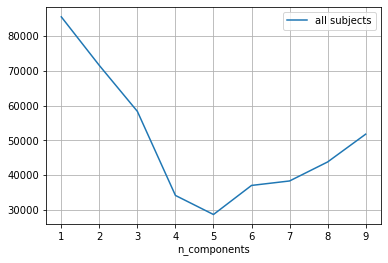

In [49]:
fit_data = t_score1
n_components = np.arange(1, 10)
models = [GMM(n, covariance_type='full', random_state=0).fit(fit_data)
          for n in n_components]

plt.plot(n_components, [m.bic(fit_data) for m in models], label='BIC')
plt.legend(['all subjects'],loc='best')

plt.xlabel('n_components');
plt.grid()

In [62]:
print(t_score1.shape)
print(np.concatenate((t_score1, t_score2),axis=1).shape)

(106, 70)
(106, 140)


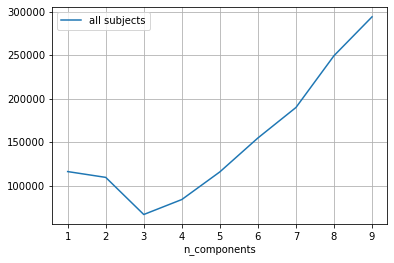

In [63]:
fit_data = np.concatenate((t_score1, t_score2),axis=1)
n_components = np.arange(1, 10)
models = [GMM(n, covariance_type='full', random_state=0).fit(fit_data)
          for n in n_components]

plt.plot(n_components, [m.bic(fit_data) for m in models], label='BIC')
plt.legend(['all subjects'],loc='best')

plt.xlabel('n_components');
plt.grid()

In [78]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance) # SVD 사용 for PCA
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, facecolor= 'steelblue',**kwargs))
###################################################################

fit_data = t_score1
fit_data = np.array(fit_data)
fit_data.shape

###################################################################
number_of_gaussian = 5
data_dimension = 70
gmm_lib1= GMM(n_components=number_of_gaussian, covariance_type='full', random_state=0)
pos1, covar1 = get_gmm_vals(gmm_lib1, fit_data, data_dimension, number_of_gaussian, label=False)
labels1 = get_gmm_labels(gmm_lib1, fit_data, data_dimension, number_of_gaussian, label=False)

centers1 = pos1
model1 = gmm_lib1
nor_labels1 = labels1

In [79]:
###################################################################

fit_data = np.concatenate((t_score1, t_score2),axis=1)
fit_data = np.array(np.concatenate((t_score1, t_score2),axis=1))
fit_data.shape

###################################################################
number_of_gaussian = 3
data_dimension = 140
gmm_lib2= GMM(n_components=number_of_gaussian, covariance_type='full', random_state=0)
pos2, covar2 = get_gmm_vals(gmm_lib2, fit_data, data_dimension, number_of_gaussian, label=False)
labels2 = get_gmm_labels(gmm_lib2, fit_data, data_dimension, number_of_gaussian, label=False)

centers2 = pos2
model2 = gmm_lib2
nor_labels2 = labels2

In [81]:
print(labels1)
print(labels2)

[2 4 3 2 3 0 1 1 1 2 1 2 2 2 1 1 1 2 4 4 1 4 1 4 4 1 3 3 1 2 1 3 2 1 3 2 4
 3 1 1 1 1 1 4 1 1 1 2 1 4 3 3 4 2 4 3 1 1 1 2 3 4 2 3 1 2 3 4 3 3 1 0 4 2
 4 1 3 0 0 3 2 3 3 3 3 3 1 0 4 3 3 3 1 2 1 4 3 0 0 0 0 0 1 0 0 0]
[2 1 1 2 1 0 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 1 2 2 2 1 2 2 1 2 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 1 1 2 1 2 2 1 1 2 1 2 2 1 1 1 1 1 0 1 0
 2 2 1 0 0 1 2 1 1 1 1 1 2 0 1 1 1 1 2 2 2 1 1 0 0 0 0 0 2 0 0 0]


Text(0.5, 0, 'feature 11')

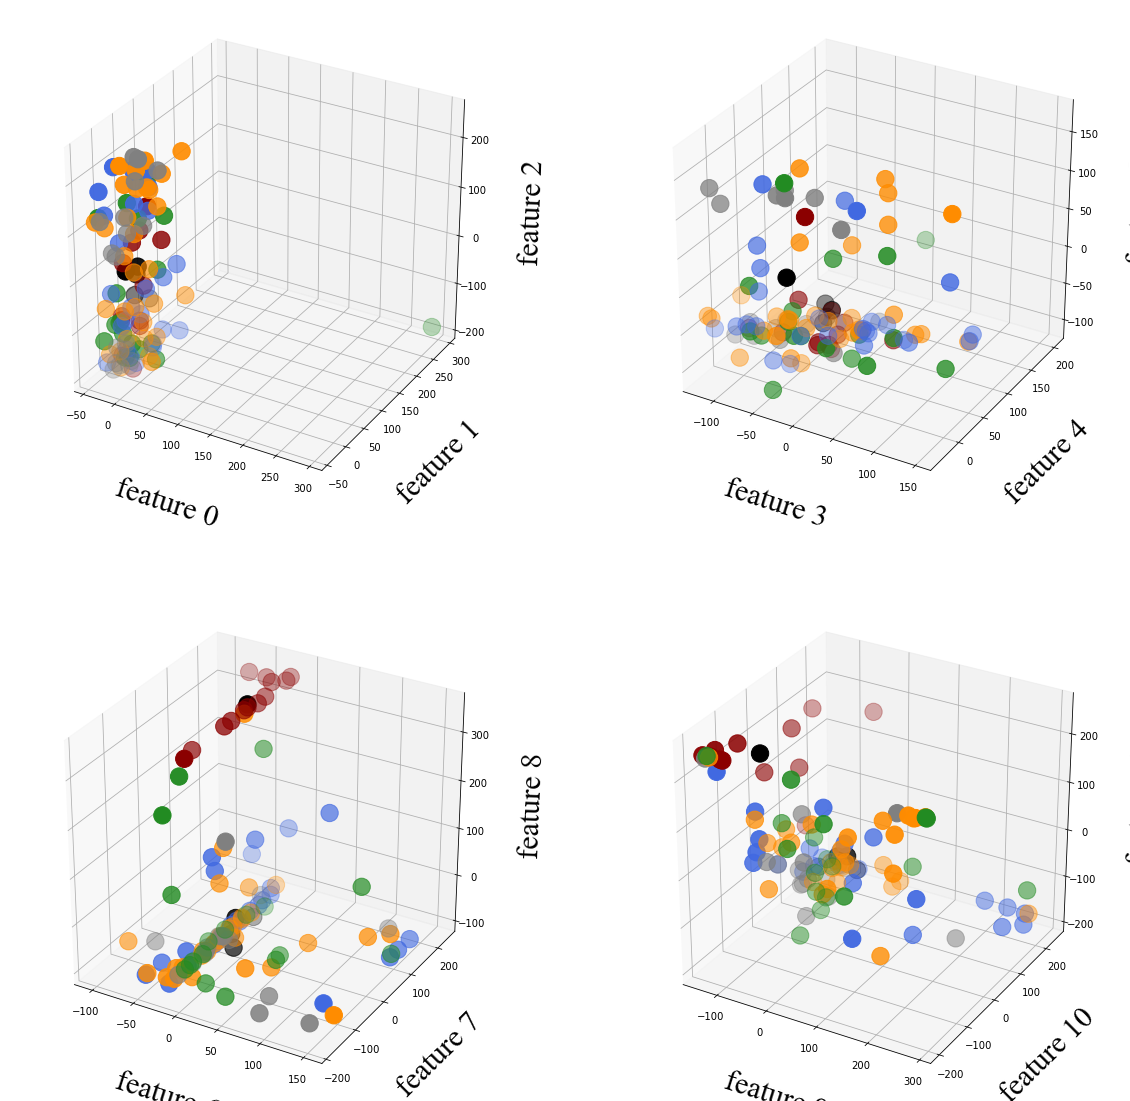

In [82]:
labelsize = 30
labelpad = 30
ticksize = 30
centersize = 300
aa = 0.5
colors = ['darkred','darkorange','forestgreen','royalblue', 'gray']
number_of_gaussian = 5

fig = plt.figure(figsize = (20,20))

ax = fig.add_subplot(221, projection='3d')
x = t_score1[:,0] # feature 0
y = t_score1[:,1] # feature 1
z = t_score1[:,2] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels1==lit],y[labels1==lit],z[labels1==lit],c=colors[lit],s = centersize)
x = centers1[:,0]
y = centers1[:,1]
z = centers1[:,2]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 0',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 1',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 2',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(222, projection='3d')
x = t_score1[:,3] # feature 0
y = t_score1[:,4] # feature 1
z = t_score1[:,5] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels1==lit],y[labels1==lit],z[labels1==lit],c=colors[lit],s = centersize)
x = centers1[:,3]
y = centers1[:,4]
z = centers1[:,5]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 3',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 4',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 5',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(223, projection='3d')
x = t_score1[:,6] # feature 0
y = t_score1[:,7] # feature 1
z = t_score1[:,8] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels1==lit],y[labels1==lit],z[labels1==lit],c=colors[lit],s = centersize)
x = centers1[:,6]
y = centers1[:,7]
z = centers1[:,8]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 6',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 7',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 8',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(224, projection='3d')
x = t_score1[:,9] # feature 0
y = t_score1[:,10] # feature 1
z = t_score1[:,11] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels1==lit],y[labels1==lit],z[labels1==lit],c=colors[lit],s = centersize)
x = centers1[:,9]
y = centers1[:,10]
z = centers1[:,11]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 9',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 10',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 11',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

Text(0.5, 0, 'feature 11')

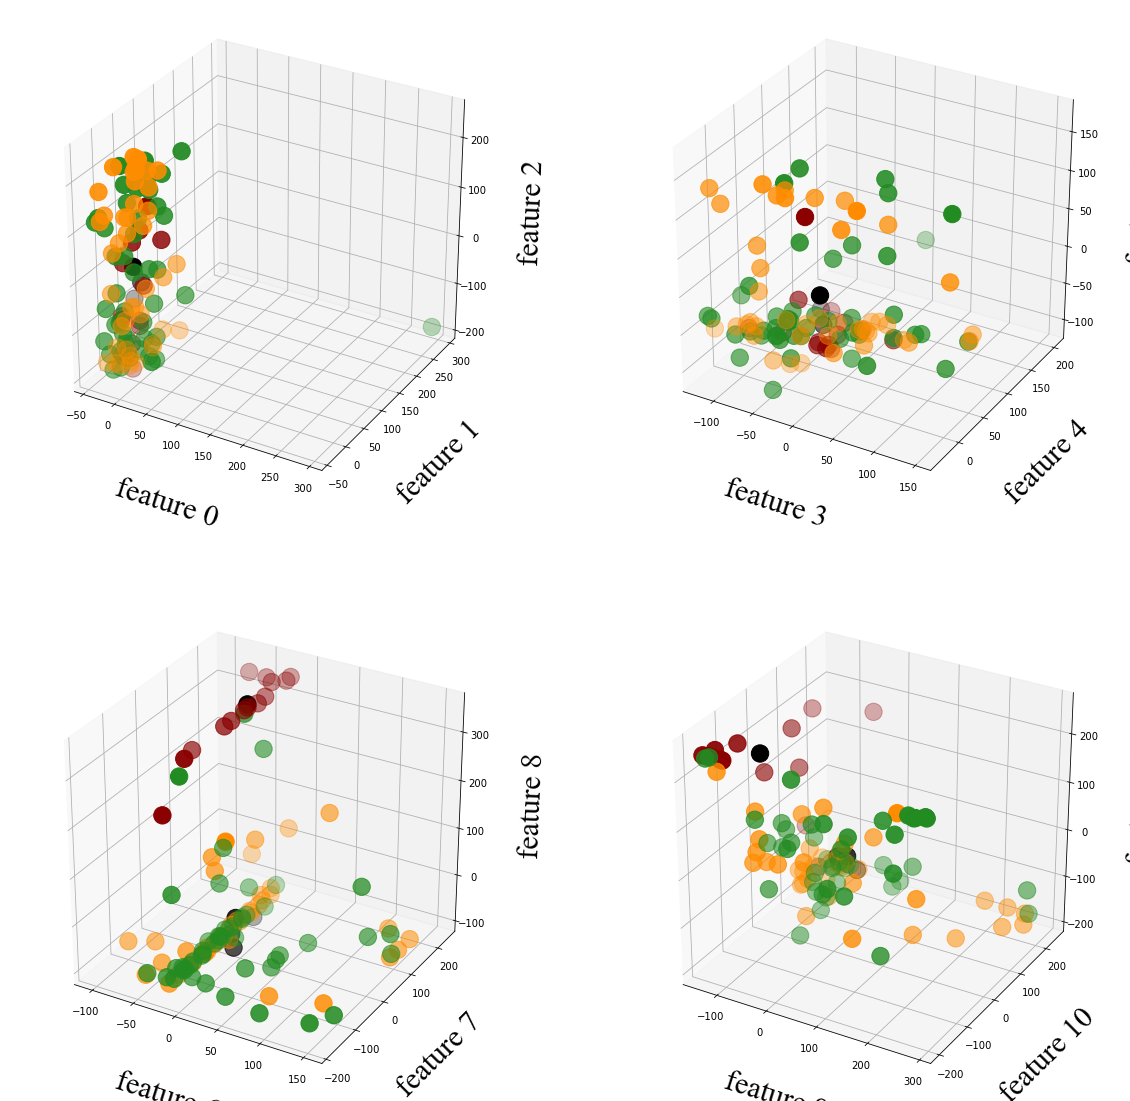

In [83]:
labelsize = 30
labelpad = 30
ticksize = 30
centersize = 300
aa = 0.5
colors = ['darkred','darkorange','forestgreen','royalblue', 'gray']
number_of_gaussian = 3

fig = plt.figure(figsize = (20,20))

ax = fig.add_subplot(221, projection='3d')
x = t_score1[:,0] # feature 0
y = t_score1[:,1] # feature 1
z = t_score1[:,2] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels2==lit],y[labels2==lit],z[labels2==lit],c=colors[lit],s = centersize)
x = centers2[:,0]
y = centers2[:,1]
z = centers2[:,2]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 0',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 1',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 2',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(222, projection='3d')
x = t_score1[:,3] # feature 0
y = t_score1[:,4] # feature 1
z = t_score1[:,5] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels2==lit],y[labels2==lit],z[labels2==lit],c=colors[lit],s = centersize)
x = centers2[:,3]
y = centers2[:,4]
z = centers2[:,5]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 3',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 4',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 5',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(223, projection='3d')
x = t_score1[:,6] # feature 0
y = t_score1[:,7] # feature 1
z = t_score1[:,8] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels2==lit],y[labels2==lit],z[labels2==lit],c=colors[lit],s = centersize)
x = centers1[:,6]
y = centers1[:,7]
z = centers1[:,8]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 6',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 7',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 8',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

ax = fig.add_subplot(224, projection='3d')
x = t_score1[:,9] # feature 0
y = t_score1[:,10] # feature 1
z = t_score1[:,11] # feature 2
for lit in range(number_of_gaussian):
    ax.scatter(x[labels2==lit],y[labels2==lit],z[labels2==lit],c=colors[lit],s = centersize)
x = centers1[:,9]
y = centers1[:,10]
z = centers1[:,11]
ax.scatter(x,y,z,c='k',s = centersize)
ax.set_xlabel('feature 9',size = labelsize,labelpad = labelpad, fontname="Times New Roman")
ax.set_ylabel('feature 10',size = labelsize,labelpad = labelpad,fontname="Times New Roman")
ax.set_zlabel('feature 11',size = labelsize,labelpad = labelpad,fontname="Times New Roman")

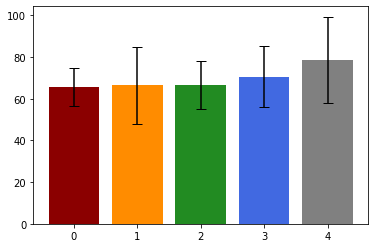

In [98]:
# Weight
qkey = 'Weight'
fig, ax = plt.subplots()
for lit in range(0,5):
    plt.bar(lit, np.mean(gtlist[labels1==lit][qkey]),color=colors[lit])
    plt.errorbar(lit,np.mean(gtlist[labels1==lit][qkey]),np.std(gtlist[labels1==lit][qkey]),ecolor='k',capsize=5)

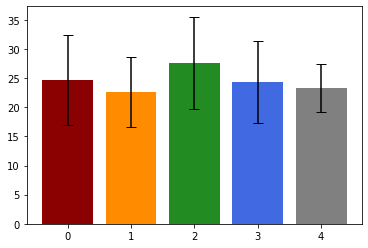

In [99]:
# Age
qkey = 'Age'
fig, ax = plt.subplots()
for lit in range(0,5):
    plt.bar(lit, np.mean(gtlist[labels1==lit][qkey]),color=colors[lit])
    plt.errorbar(lit,np.mean(gtlist[labels1==lit][qkey]),np.std(gtlist[labels1==lit][qkey]),ecolor='k',capsize=5)

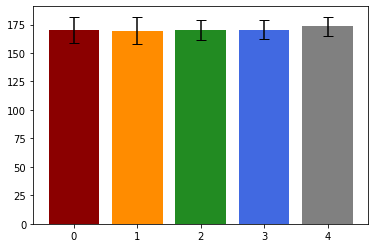

In [100]:
# Height
qkey = 'Height (CM)'
fig, ax = plt.subplots()
for lit in range(0,5):
    plt.bar(lit, np.mean(gtlist[labels1==lit][qkey]),color=colors[lit])
    plt.errorbar(lit,np.mean(gtlist[labels1==lit][qkey]),np.std(gtlist[labels1==lit][qkey]),ecolor='k',capsize=5)

In [108]:
# Smoker
qkey = 'smoker'
smoker_table = pd.DataFrame({'Yes':[],'No':[]})
for lit in range(0,5):
    qlabel = gtlist[labels1==lit][qkey]
    n_no = qlabel[qlabel=='No'].size
    n_yes = qlabel[qlabel=='Yes'].size
    smoker_table = smoker_table.append(pd.DataFrame({'Yes':[(n_yes)/(n_yes+n_no)],'No':[(n_no)/(n_yes+n_no)]}))
print(smoker_table)

        Yes        No
0  0.000000  1.000000
0  0.187500  0.812500
0  0.222222  0.777778
0  0.038462  0.961538
0  0.000000  1.000000


In [109]:
# Gender
qkey = 'gender'
smoker_table = pd.DataFrame({'Male':[],'Female':[]})
for lit in range(0,5):
    qlabel = gtlist[labels1==lit][qkey]
    n_m = qlabel[qlabel=='M'].size
    n_f = qlabel[qlabel=='F'].size
    smoker_table = smoker_table.append(pd.DataFrame({'Male':[(n_m)/(n_m+n_f)],'Female':[(n_f)/(n_m+n_f)]}))
print(smoker_table)

       Male    Female
0  0.461538  0.538462
0  0.500000  0.500000
0  0.500000  0.500000
0  0.653846  0.346154
0  0.705882  0.294118


In [86]:
print(gtlist)

     Weight  Age  Height (CM) smoker gender
0        68   30          180     No      M
1        68   30          180     No      M
2        60   24          159     No      F
3        60   24          159     No      F
4        78   35          168     No      F
..      ...  ...          ...    ...    ...
101      70   20          170     No      M
102      72   32          175     No      M
103      61   20          170     No      F
104      79   21          170     No      F
105      54   19          204     No      F

[106 rows x 5 columns]


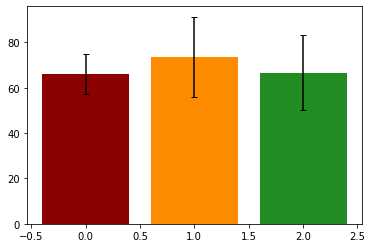

In [110]:
# Weight
qkey = 'Weight'
fig, ax = plt.subplots()
for lit in range(0,3):
    plt.bar(lit, np.mean(gtlist[labels2==lit][qkey]),color=colors[lit])
    plt.errorbar(lit,np.mean(gtlist[labels2==lit][qkey]),np.std(gtlist[labels2==lit][qkey]),ecolor='k',capsize=3)

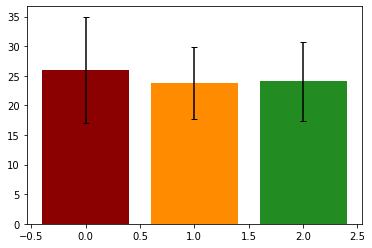

In [111]:
# Age
qkey = 'Age'
fig, ax = plt.subplots()
for lit in range(0,3):
    plt.bar(lit, np.mean(gtlist[labels2==lit][qkey]),color=colors[lit])
    plt.errorbar(lit,np.mean(gtlist[labels2==lit][qkey]),np.std(gtlist[labels2==lit][qkey]),ecolor='k',capsize=3)

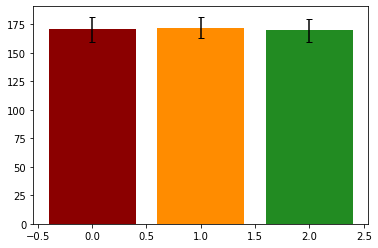

In [112]:
# Height
qkey = 'Height (CM)'
fig, ax = plt.subplots()
for lit in range(0,3):
    plt.bar(lit, np.mean(gtlist[labels2==lit][qkey]),color=colors[lit])
    plt.errorbar(lit,np.mean(gtlist[labels2==lit][qkey]),np.std(gtlist[labels2==lit][qkey]),ecolor='k',capsize=3)

In [114]:
# Smoker
qkey = 'smoker'
smoker_table = pd.DataFrame({'Yes':[],'No':[]})
for lit in range(0,3):
    qlabel = gtlist[labels2==lit][qkey]
    n_no = qlabel[qlabel=='No'].size
    n_yes = qlabel[qlabel=='Yes'].size
    smoker_table = smoker_table.append(pd.DataFrame({'Yes':[(n_yes)/(n_yes+n_no)],'No':[(n_no)/(n_yes+n_no)]}))
print(smoker_table)

        Yes        No
0  0.000000  1.000000
0  0.046512  0.953488
0  0.183673  0.816327


In [115]:
# Gender
qkey = 'gender'
smoker_table = pd.DataFrame({'Male':[],'Female':[]})
for lit in range(0,3):
    qlabel = gtlist[labels2==lit][qkey]
    n_m = qlabel[qlabel=='M'].size
    n_f = qlabel[qlabel=='F'].size
    smoker_table = smoker_table.append(pd.DataFrame({'Male':[(n_m)/(n_m+n_f)],'Female':[(n_f)/(n_m+n_f)]}))
print(smoker_table)

       Male    Female
0  0.428571  0.571429
0  0.674419  0.325581
0  0.510204  0.489796


In [86]:
print(gtlist)

     Weight  Age  Height (CM) smoker gender
0        68   30          180     No      M
1        68   30          180     No      M
2        60   24          159     No      F
3        60   24          159     No      F
4        78   35          168     No      F
..      ...  ...          ...    ...    ...
101      70   20          170     No      M
102      72   32          175     No      M
103      61   20          170     No      F
104      79   21          170     No      F
105      54   19          204     No      F

[106 rows x 5 columns]


In [162]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN, LSTM, Activation, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

In [200]:
#def rnnmodel(input_shape):
#    ipt= Input(shape=input_shape)
#    X = SimpleRNN(128)(ipt)
#    X = Dropout(0.5)(X)
#    X = SimpleRNN(128)(X)
#    X = Dropout(0.5)(X)
#    X = Dense(2, activation='softmax')(X)
#    X = Activation('softmax')(X)
#    model = Model(Input, X)
#    return model

def linmodel(in_shape):
    model = tf.keras.Sequential()
    model.add(Dense(128, activation='relu', input_shape=in_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.add(Activation('softmax'))
    return model

def rnnmodel(in_shape):
    model = tf.keras.Sequential([
        SimpleRNN(128,input_shape = in_shape),
        Dropout(0.5),
        SimpleRNN(128),
        Dropout(0.5),
        Dense(2, activation='softmax'),
        Activation('softmax')
    ])
    return model


def lstmmodel(input_shape):
    ipt = Input(shape=input_shape)
    X = LSTM(128)(ipt)
    X = Dropout(0.5)(X)
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)
    X = Dense(2, activation='softmax')(X)
    X = Activation('softmax')(X)
    model = Model(Input, X)
    return model

In [122]:
label_smoker = 1*np.array(gtlist['smoker']=='Yes')
label_male = 1*np.array(gtlist['gender']=='M')
print(label_smoker)
print(label_male)

[0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0
 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0]


In [196]:
ranidx = np.random.choice(range(t_score1.shape[0]), 70, replace=False)
print(ranidx)
print(t_score1[ranidx].shape)
print(np.delete(t_score1, ranidx, 0).shape)

[ 72  65  85  97  54   0  81  43  57  69  88  34 104  46  40  12  23  26
  14  22   7  78  27  30  90  18  84  93  92  76  16  66 100  31  49   9
  98  91  87  15  19 105  11  71  59  45  28  68  75  67  53  94  44  60
  47  13  86  50  10  51  58  25  82  73  52 102  29  64  24  70]
(70, 70)
(36, 70)


In [201]:
traindata = t_score1[ranidx]

rmodel = linmodel(traindata[0].shape)
rmodel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
rmodel.summary()

train_history = rmodel.fit(traindata, label_smoker[ranidx], epochs=100, batch_size=32, shuffle=True)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               9088      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_13 (Activation)   (None, 2)                 0         
Total params: 25,858
Trainable params: 25,858
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 999us/step - loss: 0.8067 - accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 0s 665us/step - loss: 0.8116 - accuracy: 0.5000
Epoch 3/100
3/3 [==============================] 

3/3 [==============================] - 0s 665us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 72/100
3/3 [==============================] - 0s 997us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 73/100
3/3 [==============================] - 0s 665us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 74/100
3/3 [==============================] - 0s 664us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 75/100
3/3 [==============================] - 0s 665us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 76/100
3/3 [==============================] - 0s 665us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 77/100
3/3 [==============================] - 0s 664us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 78/100
3/3 [==============================] - 0s 665us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 79/100
3/3 [==============================] - 0s 665us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 80/100
3/3 [==============================] - 0s 997us/step - loss: 0.8133 - accuracy: 0.2286
Epoch 81/100


In [202]:
testdata = np.delete(t_score1, ranidx, 0)
loss, acc = rmodel.evaluate(testdata, np.delete(label_smoker, ranidx, 0))

2/2 [==============================] - 0s 512us/step - loss: 0.8133 - accuracy: 0.1944


In [203]:
predicted_label = rmodel.predict(testdata).argmax(axis=1)
print(predicted_label)
print(np.delete(label_smoker, ranidx, 0))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
